In [83]:
from astropy.stats import sigma_clipped_stats
from photutils.datasets import load_star_image
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch
from rasterio.windows import Window, from_bounds
from rasterio.plot import show, show_hist
import numpy as np
import matplotlib.pyplot as plt
import rasterio

In [84]:
image = rasterio.open('../images/SVDNB_npp_20210301-20210331_global_vcmslcfg_v10_c202104061200.avg_rade9h.tif')

In [85]:
image.shape

(33601, 86401)

In [86]:
image.bounds

BoundingBox(left=-180.00208333335, bottom=-65.00208445335001, right=180.00208621335, top=75.00208333335)

In [87]:
us_bounding = (-126.0,22.9,-50.98,54.59)

In [88]:
us_window = from_bounds(us_bounding[0], us_bounding[1], us_bounding[2], us_bounding[3], image.transform)

In [89]:
data = image.read(1, window= us_window)

In [90]:
data[data<0] = 0

<ipython-input-91-cf0a45a25449>:1: RuntimeWarning: divide by zero encountered in log
  show(np.log(data),with_bounds=True)


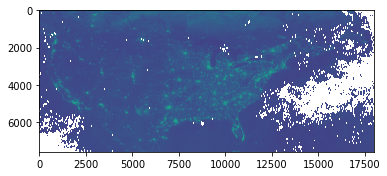

<AxesSubplot:>

In [91]:
show(np.log(data),with_bounds=True)

In [92]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0)  

In [93]:
print(mean,median,std)

0.29280937 0.27 0.11547308


In [94]:
from photutils.detection import DAOStarFinder

In [95]:
daofind = DAOStarFinder(fwhm=3.0, threshold=7.*std) 

In [118]:
sources = daofind(data-median)

In [119]:
psources = sources.to_pandas()

In [120]:
us_window

Window(col_off=12960.499896319998, row_off=4898.899960812798, width=18004.7998559616, height=7605.599939155201)

In [137]:
psources = psources.assign(x = (psources.ycentroid + us_window.row_off), 
                           y = (psources.xcentroid + us_window.col_off))

In [138]:
def to_coord(x,y):
    return image.xy(x,y)

In [139]:
lngs = psources[['x','y']].apply(lambda x: to_coord(x.x,x.y)[0] ,axis=1)
lats = psources[['x','y']].apply(lambda x: to_coord(x.x,x.y)[1] ,axis=1)

In [140]:
psources = psources.assign(lat=lats, lng=lngs)

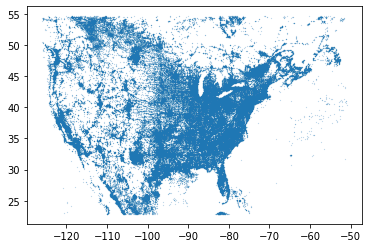

In [141]:
plt.scatter(psources.lng, psources.lat, s=0.01)

In [160]:
psources.to_csv("sources.csv",index=False)

## Filter down

In [2]:
import geopandas as gp
import pandas as pd 

/home/stuart/.local/share/virtualenvs/lightpolution-gdlcOgeT/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
psources = pd.read_csv('sources.csv')

In [4]:
boundaries = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))

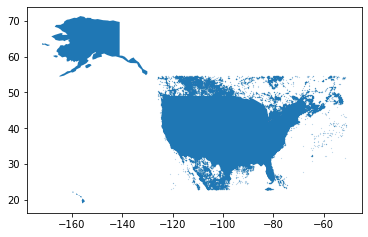

In [5]:
ax = boundaries[boundaries['iso_a3']=='USA'].plot()
ax.scatter(psources.lng, psources.lat, s=0.01)

In [6]:
incorp = gp.read_file("../ETL/done/incorporated_places.geojson")

In [7]:
geo_sources = gp.GeoDataFrame(psources, geometry=gp.points_from_xy(psources.lng,psources.lat), crs='epsg:4326')

In [10]:
in_incorporated = gp.sjoin(incorp,geo_sources)

In [16]:
non_incorporated =geo_sources[~geo_sources['id'].isin(in_incorporated['id'].values)]

In [24]:
non_incorporated = gp.sjoin(boundaries[['iso_a3','geometry']],non_incorporated)

In [32]:
non_incorporated= non_incorporated[non_incorporated['iso_a3']=='USA'].drop(['geometry','iso_a3','index_right'],axis=1)

In [33]:
non_incorporated.to_csv("non_incorporated_places.csv",index=False)

In [34]:
gp.GeoDataFrame(non_incorporated,geometry=gp.points_from_xy(non_incorporated.lng, non_incorporated.lat), crs='epsg:4326').to_file("non_incorporated_places.geojson",driver='GeoJSON')

In [ ]:
non